In [70]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from matplotlib.colors import LogNorm
from pyfcd.fcd import calculate_carriers, fcd
from scipy.signal.windows import tukey

estilo_graficos = ["science", "nature"]
cm = 1/2.54
texto_pt = 8
proporciones = (8*cm, 6*cm)
dpi = 150 #@param

plt.style.use(estilo_graficos)
font_size_dict = {"axes.labelsize": texto_pt, "xtick.labelsize": texto_pt, "ytick.labelsize": texto_pt, "legend.fontsize": texto_pt, "font.size": texto_pt}
plt.rcParams.update(font_size_dict)
plt.rcParams['figure.figsize'] = proporciones
plt.rcParams['figure.dpi'] = dpi

In [71]:
# AUXILIARY FUNCTIONS

def beautify_axs(ax, title="", labels=["",""], multiply=None, legend_kwargs=None, grid=False, \
                 aspect="auto", xlim=None, ylim=None, margins=(0,0)):

    ax.set_title(title, ha='left', position=(0, 1))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.margins(*margins)

    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)

    if multiply is not None:
        xticks = np.array(ax.get_xticks())
        yticks = np.array(ax.get_yticks())
        ax.set_xticks(xticks, labels=np.round(xticks*multiply[0], 2))
        ax.set_yticks(yticks, labels=np.round(yticks*multiply[1], 2))

    ax.set_aspect(aspect)
    if legend_kwargs is not None: ax.legend(**legend_kwargs)
    if grid: ax.grid()

    return None

In [72]:
def get_checkerboard_pattern(square_size):
    def pattern(x,y):
        return  0.5 + np.real(np.exp(2j*np.pi*((x+y)/(2*square_size))) + np.exp(2j*np.pi*((x-y)/(2*square_size))))/4
    return pattern

def get_inverse_displacement(height_map_gradient, H, hp, alpha):
    def inverse_displacement(X, Y):
        R = np.sqrt(X**2 + Y**2)
        hstar = (1/(alpha*hp) - 1/H)**(-1)
        hstar = alpha*hp
        i = R/H
        
        O_Mpp = np.array([X,Y])
        Mp_Mpp = - height_map_gradient*hstar
        O_Mp = O_Mpp - Mp_Mpp

        e_r = O_Mp / np.sqrt(O_Mp[0]**2 + O_Mp[1]**2)
        O_M = O_Mp - alpha*hp*i*e_r
        return O_M

    return inverse_displacement

In [73]:
# PATTERN PARAMETERS
square_size = 1e-3  # [m] Tamaño de los cuadrados del patrón _checkerboard_
window_size = 20e-2
resolution  = window_size/1024

USE_WINDOW = True

# SETUP PARAMETERS
H = 1e5             # [m] Distancia entre la camara y el patrón
n_aire = 1          # Índice de refracción del aire
n_agua = 1.33       # Índice de refracción del agua
n_vidrio = 1.5      # Índice de refracción del vidrio
hp = 10e-2 + 1e-2*n_agua/n_aire + 1e-2*n_agua/n_vidrio  # [m] Grosor efectivo del fluído con desviaciones nulas
alpha = 1 - n_aire/n_agua

# WAVE PARAMETERS
U0 = 5e-3     # [m]
lamda = 10e-2 # [m]

# PATTERN GENERATION
x = np.arange(-window_size/2, window_size/2, resolution)  # [m]
y = np.arange(-window_size/2, window_size/2, resolution)  # [m]
X, Y = np.meshgrid(x, y)

height_map_in = hp + U0*np.sin(2*np.pi*X/lamda)
gradient      = np.array(np.gradient(height_map_in, resolution))[::-1]

inverse_displacement = get_inverse_displacement(gradient, H, hp, alpha)
pattern = get_checkerboard_pattern(square_size)

# WINDOWING
window1dx = np.abs(tukey(len(x), 0.1))
window1dy = np.abs(tukey(len(y), 0.1))
window2d = np.sqrt(np.outer(window1dx, window1dy))

i_ref = pattern(X, Y)*window2d if USE_WINDOW else pattern(X, Y)
i_def = pattern(*inverse_displacement(X, Y))*window2d if USE_WINDOW else pattern(*inverse_displacement(X, Y))

In [74]:
# TESTS
Kc = 2*np.pi/(2*square_size)
Ks = 2*np.pi/lamda

lamda_c = 2*square_size
lamda_s = lamda

Us = hp*alpha*U0*Ks

print("test 1\n", f"\tλs: {lamda_s}\n", f"\tλc: {lamda_c}\n", f"\tλc/λs = {lamda_c/lamda_s}\n", f"\tλc/λs < 1: {lamda_c/lamda_s < 1}\n")

print("test 2\n", f"\tKs: {Ks}\n", f"\tUs: {Us}\n", f"\t(Ks*Us)√2 = {Ks*Us*np.sqrt(2)}\n" , f"\t(Ks*Us)√2 < 1: {Ks*Us*np.sqrt(2) < 1}\n")

print("Nyquist-Shannon\n", f"\tλc: {lamda_c}\n", f"\tlimit: {6*resolution}\n", f"\tλc > limit: {lamda_c > 6*resolution}\n")

test 1
 	λs: 0.1
 	λc: 0.002
 	λc/λs = 0.02
 	λc/λs < 1: True

test 2
 	Ks: 62.83185307179586
 	Us: 0.00952280509996034
 	(Ks*Us)√2 = 0.8461741660404254
 	(Ks*Us)√2 < 1: True

Nyquist-Shannon
 	λc: 0.002
 	limit: 0.0011718750000000002
 	λc > limit: True



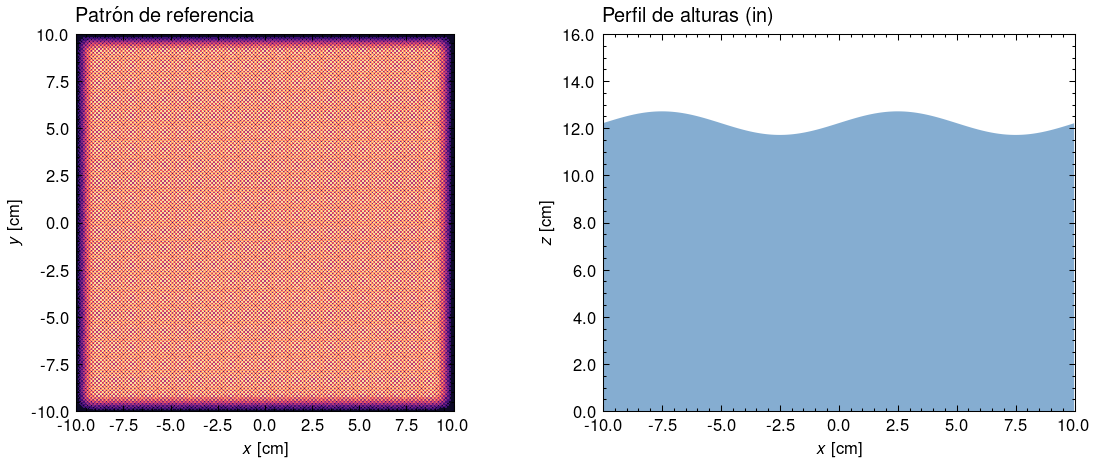

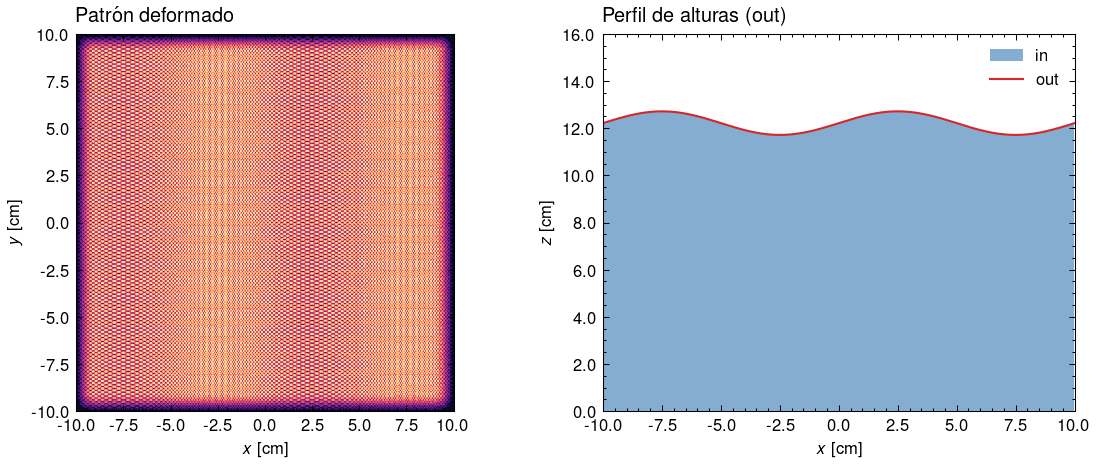

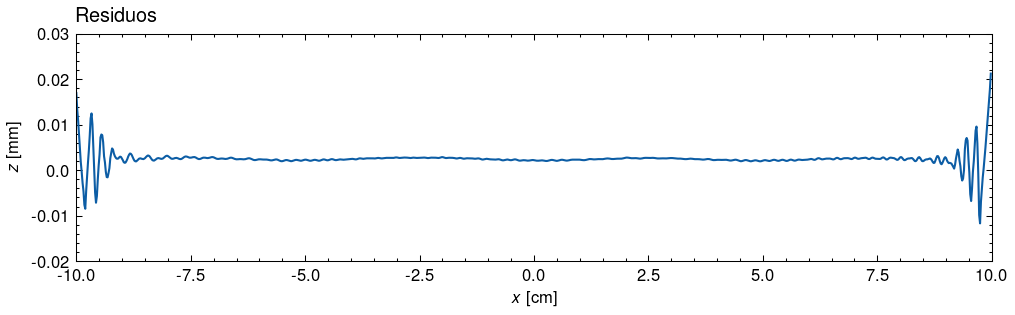

In [75]:
# FCD IN
fig, axs = plt.subplots(1, 2, figsize=(20*cm, 8*cm))
fig.tight_layout(pad=2)

axs[0].contourf(X, Y, i_ref, cmap="magma")
beautify_axs(axs[0], title="Patrón de referencia", labels=["$x$ [cm]", "$y$ [cm]"], multiply=[1e2,1e2], aspect="equal")

axs[1].fill_between(X[0,:], height_map_in[0,:], alpha=0.5)
beautify_axs(axs[1], title="Perfil de alturas (in)", labels=["$x$ [cm]", "$z$ [cm]"], multiply=[1e2,1e2], ylim=(0,hp+2*Us), aspect="equal")

plt.show()

# FCD OUT
carriers = calculate_carriers(i_ref, square_size=square_size)
height_map_out = hp + fcd(i_def, carriers, h=hp*alpha, unwrap=True)

fig, axs = plt.subplots(1, 2, figsize=(20*cm, 8*cm))
fig.tight_layout(pad=2)

axs[0].contourf(X, Y, i_def, cmap="magma")
beautify_axs(axs[0], title="Patrón deformado", labels=["$x$ [cm]", "$y$ [cm]"], multiply=[1e2,1e2], aspect="equal")

axs[1].fill_between(X[0,:], height_map_in[0,:], alpha=0.5, label="in")
axs[1].plot(X[0,:], height_map_out[0,:], color="tab:red", label="out")
beautify_axs(axs[1], title="Perfil de alturas (out)", labels=["$x$ [cm]", "$z$ [cm]"], multiply=[1e2,1e2], ylim=(0,hp+2*Us), aspect="equal", legend_kwargs={"loc":"upper right"})

# RESIDUALS
residuals = (height_map_out[0,:] - height_map_in[0,:])
fig, axs = plt.subplots(1, 1, figsize=(20*cm, 5*cm))

axs.plot(X[0,:], residuals)
beautify_axs(axs, title="Residuos", labels=["$x$ [cm]", "$z$ [mm]"], multiply=[1e2,1e3])

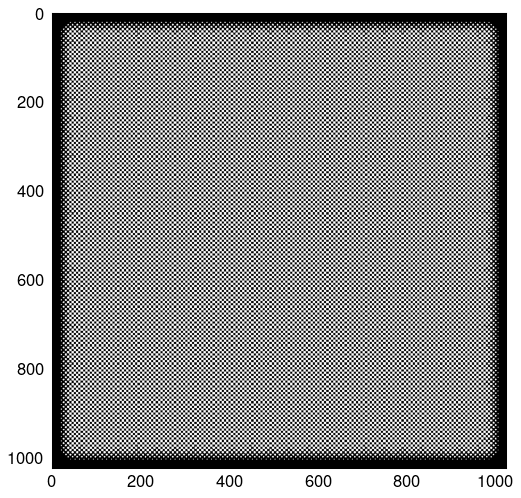

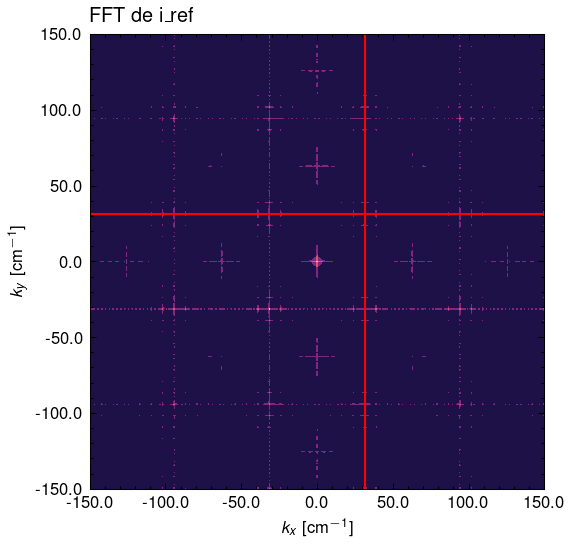

In [76]:
# TRANSFORMADAS DE FOURIER
from scipy.fft import fft2, fftshift, fftfreq

fft_ref = fftshift(fft2((i_ref > 0.5).astype("int")))

plt.figure(figsize=(10*cm, 10*cm))
plt.imshow((i_ref > 0.5).astype("int"), cmap="Greys_r")
plt.show()

kx = fftshift(fftfreq(x.shape[-1]))*2*np.pi/resolution
ky = fftshift(fftfreq(y.shape[-1]))*2*np.pi/resolution
Kx, Ky = np.meshgrid(kx, ky)

plt.figure(figsize=(10*cm, 10*cm))
plt.contourf(Kx, Ky, np.abs(fft_ref)+100, norm=LogNorm(), cmap= "magma")

plt.axhline(np.pi/square_size, color = "red")
plt.axvline(np.pi/square_size, color = "red")

beautify_axs(plt.gca(), title="FFT de i_ref", aspect="equal", 
             labels=["$k_x$ [cm$^{-1}$]", "$k_y$ [cm$^{-1}$]"], multiply=[1e-2,1e-2], 
             xlim=[-4*np.pi/square_size, 4*np.pi/square_size], 
             ylim=[-4*np.pi/square_size, 4*np.pi/square_size])
plt.show()